In [1]:
# %matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.font_manager as fm
[f.name for f in fm.fontManager.ttflist if "Garamond" in f.name]
from matplotlib import rcParams

sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})

In [2]:
# from phys.plot_scripts.decoding_summary import PlotHelper
from utils.decoding_summary import PlotHelper

In [3]:
from utils import generic_plot_utils as rr_gpu

In [4]:
    def plot_decode_performance_unrolled_over_time(self, time_idx=None, compute_egocentric=False):

        if compute_egocentric:  ###
            beh_idx_mat = [6, 7]
            file_suffix = 'egocentric'
        else:
            beh_idx_mat = [0, 1]
            file_suffix = 'allocentric'
        def plot_average_metric(res):
            cmap = plt.get_cmap('Dark2', 8) # green, red, blue, magenta, brightGreen, yellow, 6brown, 7grey
            f, axes = plt.subplots(1, 3, figsize=(7.5, 3))
            for ax_i, met in enumerate(['r_mu', 'mae_mu', 'mse_mu']):
                ax = axes[ax_i]
                for beh_idx in beh_idx_mat: ####
                    mu, sig = [], []
                    x_for_stat = []
                    for mi, mask_fn in enumerate(['start_occ_pad0', 'occ_end_pad0']):
                        x = res[mask_fn][met][:, beh_idx]
                        mu.append(np.nanmean(x, axis=0))
                        sig.append(np.nanstd(x, axis=0))
                        x_for_stat.append(x)

                    # ranksums
                    # stat_object = ranksums(x_for_stat[0],x_for_stat[1])
                    stat_object = wilcoxon(x_for_stat[1])
                    p_value = stat_object.pvalue

                    # # permutation_test
                    # p_value = permutation_test(x_for_stat[0],x_for_stat[1],
                    #                            method='approximate',
                    #                            num_rounds=1000,
                    #                            seed=0)

                    print(mu)
                    print(sig)
                    ax.errorbar(range(2), mu, yerr=sig, fmt='-o', mfc='w', mec=cmap(beh_idx), color=cmap(beh_idx),label=f'p={p_value:.2E}') # ,label='$\it{p=%2.6f}$' % p_value)
                    ax.legend()
                    ax.set_xticks([0, 1])
                    ax.set_xticklabels(['Visible \n Epoch', 'Occluded \n Epoch'])
                    ax.set_xlim([-0.25, 1.25])
                    if met == 'r_mu':
                        ax.set_ylim([0, 1])
                    else:
                        ax.set_ylim([0, 10])
                    rr_gpu.make_axis_nice(ax)

            plt.tight_layout()
            return f, axes

        def plot_timecourse_of_error(res,subject_id):
            f, axes = plt.subplots(1, 4, figsize=(8, 4))
            ylim_all = [0, 7]
            for mfi, mask_fn in enumerate(['start_occ_pad0', 'occ_end_pad0']):
                rmse_alignstart = (res[mask_fn]['mse_t'][:, :, beh_idx_mat[0]] + res[mask_fn]['mse_t'][:, :, beh_idx_mat[1]]) ** 0.5 ####
                rmse_alignend = (res[mask_fn]['mse_t2'][:, :, beh_idx_mat[0]] + res[mask_fn]['mse_t2'][:, :, beh_idx_mat[1]]) ** 0.5

                if 'start' in mask_fn:
                    min_timesteps = 15
                else:
                    min_timesteps = 14

                ax = axes[mfi * 2]
                t = np.arange(0, min_timesteps, 1)
                ax.errorbar(t, np.nanmean(rmse_alignstart[:, t], axis=0),
                            np.nanstd(rmse_alignstart[:, t], axis=0), fmt='-ko')
                ax.set_ylim(ylim_all)
                ax.axvline(0, linestyle='--', color=[0.5, 0.5, 0.5])
                rr_gpu.make_axis_nice(ax)

                np.savetxt('%s_%s_alignstart_t.csv'%(subject_id,mask_fn), t, fmt='%5.3f', delimiter=',', newline='\n')
                np.savetxt('%s_%s_alignstart_mean.csv'%(subject_id,mask_fn), np.nanmean(rmse_alignstart[:, t], axis=0), fmt='%5.3f', delimiter=',', newline='\n')
                np.savetxt('%s_%s_alignstart_std.csv'%(subject_id,mask_fn), np.nanstd(rmse_alignstart[:, t], axis=0), fmt='%5.3f', delimiter=',', newline='\n')

                ax = axes[mfi * 2 + 1]
                t = np.arange(-min_timesteps, 0, 1)
                ax.errorbar(t + 1, np.nanmean(rmse_alignend[:, t], axis=0),
                            np.nanstd(rmse_alignend[:, t], axis=0), fmt='-ko')
                ax.set_ylim(ylim_all)
                ax.axvline(0, linestyle='--', color=[0.5, 0.5, 0.5])
                rr_gpu.make_axis_nice(ax)

                np.savetxt('%s_%s_alignend_t.csv'%(subject_id,mask_fn), t + 1, fmt='%5.3f', delimiter=',', newline='\n')
                np.savetxt('%s_%s_alignend_mean.csv'%(subject_id,mask_fn), np.nanmean(rmse_alignend[:, t], axis=0), fmt='%5.3f', delimiter=',', newline='\n')
                np.savetxt('%s_%s_alignend_std.csv'%(subject_id,mask_fn), np.nanstd(rmse_alignend[:, t], axis=0), fmt='%5.3f', delimiter=',', newline='\n')

            for i in [1, 2, 3]:
                axes[i].axes.get_yaxis().set_visible(False)

            return f, axes

        res_ = self.get_metrics_unrolled_and_remasked(time_idx=time_idx)
        print(res_.shape)

        f, axes = plot_average_metric(res_)
        outfn = '%s/%s_decode_perf_over_epochs_%s.pdf' % (self.figoutpath, self.save_prefix, file_suffix)
        f.savefig(outfn)

        f, axes = plot_timecourse_of_error(res_,self.subject_id)
        outfn = '%s/%s_decode_perf_over_time_%s.pdf' % (self.figoutpath, self.save_prefix, file_suffix)
        f.savefig(outfn)
        return

In [5]:
            for mfi, mask_fn in enumerate(['start_occ_pad0', 'occ_end_pad0']):
                print( mask_fn )

start_occ_pad0
occ_end_pad0


../data//decode_all_hand_dmfc_occ_start_end_pad0_50ms_0.50_neural_responses_reliable_FactorAnalysis_50.pkl


/home/jcleckle/DMFC-decoder-simulation/code/utils/decoding_summary.py:149: RuntimeWarning: Mean of empty slice
  mae_t = np.nanmean(np.abs(x_cxt - y_cxt), axis=0)
/home/jcleckle/DMFC-decoder-simulation/code/utils/decoding_summary.py:150: RuntimeWarning: Mean of empty slice
  mse_t = np.nanmean((x_cxt - y_cxt) ** 2, axis=0)
/home/jcleckle/DMFC-decoder-simulation/code/utils/phys_utils.py:274: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(x, y)


[0.8967107701839062, 0.90894310929273]
[0.01465216941824139, 0.021344804581297106]
[0.8032656203704934, 0.8491232757763335]
[0.034278436278089006, 0.03602634079009897]
[0.845876695107022, 0.5415986171083789]
[0.07052734110468871, 0.0665224635936488]
[2.367865745528589, 2.1648622211513846]
[0.23610011750284443, 0.2464316534223179]
[nan, nan]
[nan, nan]
[nan, nan]
[nan, nan]


/home/jcleckle/DMFC-decoder-simulation/code/utils/decoding_summary.py:603: RuntimeWarning: Mean of empty slice
  mu.append(np.nanmean(x, axis=0))
/home/jcleckle/.conda/envs/dmfc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jcleckle/DMFC-decoder-simulation/code/utils/decoding_summary.py:603: RuntimeWarning: Mean of empty slice
  mu.append(np.nanmean(x, axis=0))
/home/jcleckle/.conda/envs/dmfc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


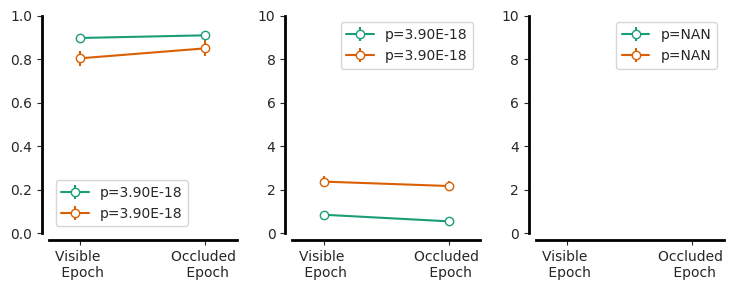

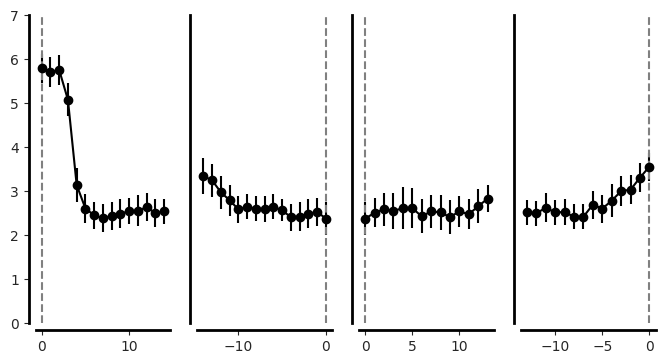

In [6]:
ph = PlotHelper(timebinsize=50,
                subject_id='all_hand_dmfc',
                masks_to_test_suffix='start_end_pad0',
                condition='occ',
                neural_data_to_use='neural_responses_reliable_FactorAnalysis_50',
                ncomp=50)

ph.load_data()
ph.load_ground_truth_data()
ph.get_colormap_for_decoded_variables()

self = ph

self.plot_decode_performance_unrolled_over_time(compute_egocentric=False)

In [7]:
res_ = self.get_metrics_unrolled_and_remasked(time_idx=None)

/home/jcleckle/DMFC-decoder-simulation/code/utils/decoding_summary.py:149: RuntimeWarning: Mean of empty slice
  mae_t = np.nanmean(np.abs(x_cxt - y_cxt), axis=0)
/home/jcleckle/DMFC-decoder-simulation/code/utils/decoding_summary.py:150: RuntimeWarning: Mean of empty slice
  mse_t = np.nanmean((x_cxt - y_cxt) ** 2, axis=0)
/home/jcleckle/DMFC-decoder-simulation/code/utils/phys_utils.py:274: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(x, y)


In [8]:
res=res_

In [9]:
 beh_idx_mat = [0, 1]

In [10]:
subject_id='all_hand_dmfc'

In [11]:
# f, axes = plt.subplots(2, 2, figsize=(12, 8))
# ylim_all = [0, 7]

# for mfi, mask_fn in enumerate(['start_occ_pad0', 'occ_end_pad0']):
#     rmse_alignstart, rmes_alignend, min_timesteps = res[mask_fn]

#     if 'start' in mask_fn:
#         min_timesteps = 15
#         baseline_mean = np.nanmean(baseline_rmse_start, axis=0)
#     else:
#         min_timesteps = 14
#         baseline_mean = np.nanmean(baseline_rmse_end, axis=0)

#     ax = axes[mfi * 2]
#     t = np.arange(0, min_timesteps, 1)
    
#     #plot neural decoding rmse 
#     ax.errorbar(t, np.nanmean(rmse_alignstart[:, t], axis=0),
#                 np.nanstd(rmse_alignstart[:, t], axis=0), fmt='-jo', label= " Neural Decoding")
    
#     # plot basline rmse 
#     ax.plot(t, baseline_mean, color='orange', linestyle='--')
#     ax.set_ylim(ylim_all)
#     ax.axvline(0, linestyle='--', color=[0.5, 0.5, 0.5])
#     rr_gpu.make_axis_nice(ax)

#     np.savetxt('%s_%s_alignstart_t.csv'%(subject_id,mask_fn), t, fmt='%5.3f', delimiter=',', newline='\n')
#     np.savetxt('%s_%s_alignstart_mean.csv'%(subject_id,mask_fn), np.nanmean(rmse_alignstart[:, t], axis=0), fmt='%5.3f', delimiter=',', newline='\n')
#     np.savetxt('%s_%s_alignstart_std.csv'%(subject_id,mask_fn), np.nanstd(rmse_alignstart[:, t], axis=0), fmt='%5.3f', delimiter=',', newline='\n')

#     ax = axes[mfi * 2 + 1]
#     t = np.arange(-min_timesteps, 0, 1)
#     ax.errorbar(t + 1, np.nanmean(rmse_alignend[:, t], axis=0),
#                 np.nanstd(rmse_alignend[:, t], axis=0), fmt='-ko')
#     ax.plot(t + 1, baseline_mean, color='orange', linestyle='--', label='Baseline')
    
#     ax.set_ylim(ylim_all)
#     ax.axvline(0, linestyle='--', color=[0.5,0.5,0.5])
#     rr_gpu.make_axis_nice(ax)

#     np.savetxt('%s_%s_alignend_t.csv'%(subject_id,mask_fn), t + 1, fmt='%5.3f', delimiter=',', newline='\n')
#     np.savetxt('%s_%s_alignend_mean.csv'%(subject_id,mask_fn), np.nanmean(rmse_alignend[:, t], axis=0), fmt='%5.3f', delimiter=',', newline='\n')
#     np.savetxt('%s_%s_alignend_std.csv'%(subject_id,mask_fn), np.nanstd(rmse_alignend[:, t], axis=0), fmt='%5.3f', delimiter=',', newline='\n')

# for i in [1, 2, 3]:
#     axes[i].axes.get_yaxis().set_visible(False)

# return f, axes


In [12]:
distance_matrix= np.load('distance_matrix.npy')

In [13]:
import sys
sys.path.append('./utils')

In [14]:
import phys_utils
import dataset_augment_utils
import data_utils

In [15]:
data = data_utils.load_neural_dataset(timebinsize=50,subject_id='all_hand_dmfc',recompute_augment=True)

data_aug = dataset_augment_utils.augment_data_structure(data)

In [16]:
mask_start_occ = data_aug['masks']['occ']['start_occ_pad0']
mask_occ_end = data_aug['masks']['occ']['occ_end_pad0']


In [17]:
mask_start_occ[1,23]

1.0

In [18]:
distance_matrix.shape

(79, 100)

In [19]:
mask_new_star_occ= ~np.isnan(mask_start_occ) 

In [20]:
mask_new_star_occ.shape

(79, 100)

In [21]:
star_occ = np.where(mask_new_star_occ,distance_matrix,np.nan) #7/18/2025

In [22]:
a=mask_start_occ*distance_matrix #7/18/2025

In [23]:
filtered_star_occ =star_occ[:,~np.isnan(star_occ).all(axis=0)] #7/18/2025

In [24]:
star_occ.shape

(79, 100)

In [25]:
filtered_star_occ.shape

(79, 37)

/tmp/ipykernel_1683441/377873161.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.arange(100)*50, np.nanmean(distance_matrix, axis=0))


Text(0, 0.5, 'Distance')

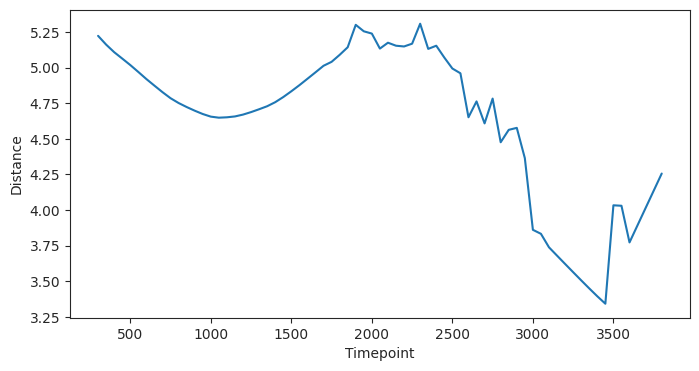

In [26]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(100)*50, np.nanmean(distance_matrix, axis=0))

plt.xlabel('Timepoint')
plt.ylabel('Distance')

In [27]:
np.arange(6,6+ 15, 1)

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

/tmp/ipykernel_1683441/2619927219.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


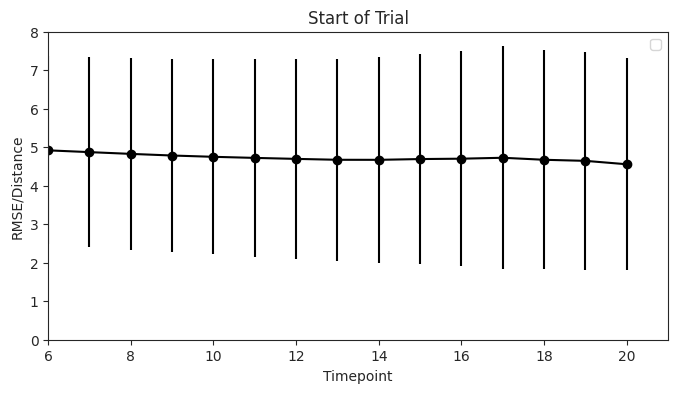

In [28]:
#Plot the avg ball pos acroos all the conditions for each valid timestamp #7/18/2025
plt.figure(figsize=(8, 4))
t = np.arange(6,6+ 15, 1)
plt.errorbar(t, np.nanmean(filtered_star_occ[:, t], axis=0),
                            np.nanstd(filtered_star_occ[:, t], axis=0), fmt='-ko')

plt.xlabel('Timepoint')
plt.ylabel('RMSE/Distance')
plt.title('Start of Trial')
plt.ylim(0,8)
plt.xlim(6,15+6)
plt.legend()
plt.show()

/tmp/ipykernel_1683441/1155953379.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


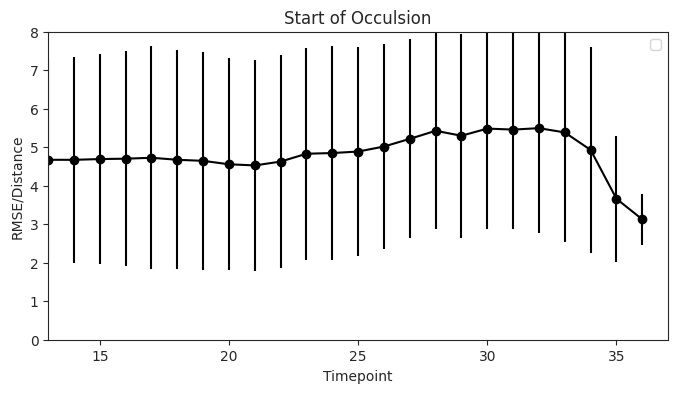

In [29]:
#Plot the avg ball pos acroos all the conditions for each valid timestamp #7/18/2025
plt.figure(figsize=(8,4))
t = np.arange(13,37, 1)
plt.errorbar(t, np.nanmean(filtered_star_occ[:, t], axis=0),
                            np.nanstd(filtered_star_occ[:, t], axis=0), fmt='-ko')

plt.xlabel('Timepoint')
plt.ylabel('RMSE/Distance')
plt.title('Start of Occulsion')
plt.ylim(0,8)
plt.xlim(13,37)
plt.legend()
plt.show()

In [30]:
mask_new_occ_end= ~np.isnan(mask_occ_end)  #7/18/2025
occ_end= np.where(mask_new_occ_end,distance_matrix,np.nan)
filtered_occ_end =occ_end[:,~np.isnan(occ_end).all(axis=0)]

In [31]:
filtered_occ_end.shape

(79, 58)

/tmp/ipykernel_1683441/1227122293.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


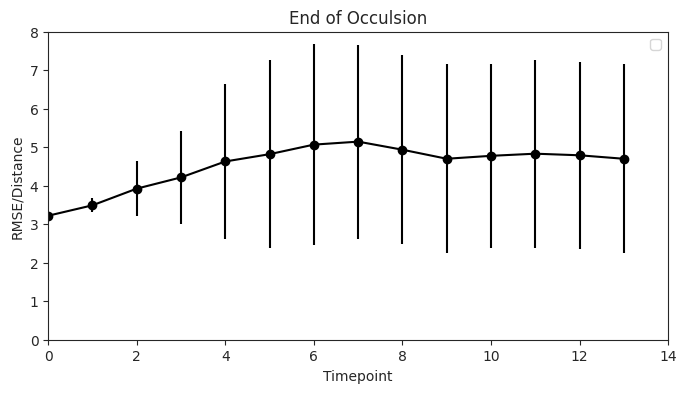

In [32]:
#Plot the avg ball pos acroos all the conditions for each valid timestamp #7/18/2025
plt.figure(figsize=(8,4))
t = np.arange(0,14, 1)
plt.errorbar(t, np.nanmean(filtered_occ_end[:, t], axis=0),
                            np.nanstd(filtered_occ_end[:, t], axis=0), fmt='-ko')

plt.xlabel('Timepoint')
plt.ylabel('RMSE/Distance')
plt.title('End of Occulsion')
plt.ylim(0,8)
plt.xlim(0,14)
plt.legend()
plt.show()

/tmp/ipykernel_1683441/3353382305.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


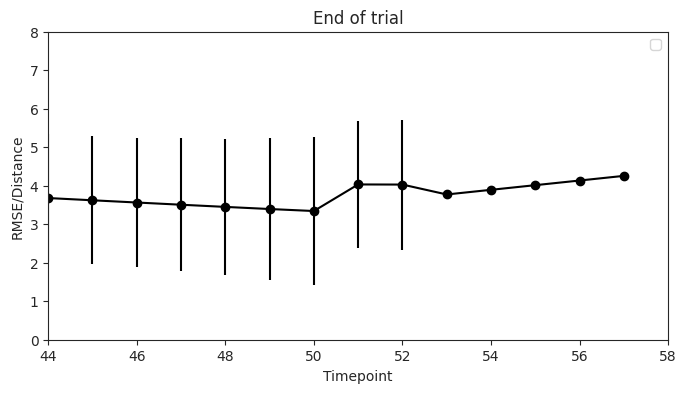

In [33]:
#Plot the avg ball pos acroos all the conditions for each valid timestamp #7/18/2025
plt.figure(figsize=(8,4))
t = np.arange(44,58, 1)
plt.errorbar(t, np.nanmean(filtered_occ_end[:, t], axis=0),
                            np.nanstd(filtered_occ_end[:, t], axis=0), fmt='-ko')

plt.xlabel('Timepoint')
plt.ylabel('RMSE/Distance')
plt.title('End of trial')
plt.ylim(0,8)
plt.xlim(44,58)
plt.legend()
plt.show()

In [34]:
import os
print([f for f in os.listdir() if f.endswith('.npy')])

['occ_end_pad0_start_decoding_mean.npy', 'distance_matrix.npy', 'occ_end_pad0_end_decoding_mean.npy', 'start_occ_pad0_end_decoding_mean.npy', 'start_occ_pad0_start_decoding_mean.npy']


In [35]:
import os
print([f for f in os.listdir() if 'mean.csv' in f])

['all_hand_dmfc_occ_end_pad0_alignend_mean.csv', 'all_hand_dmfc_ego_start_occ_pad0_alignstart_mean.csv', 'all_hand_dmfc_occ_end_pad0_alignstart_mean.csv', 'all_hand_dmfc_ego_start_occ_pad0_alignend_mean.csv', 'all_hand_dmfc_start_occ_pad0_alignstart_mean.csv', 'all_hand_dmfc_ego_occ_end_pad0_alignstart_mean.csv', 'all_hand_dmfc_ego_occ_end_pad0_alignend_mean.csv', 'all_hand_dmfc_start_occ_pad0_alignend_mean.csv']


In [36]:
time_idx = None
subject_id = 'all_hand_dmfc'

In [37]:
#load and save code decoding_mean 
time_vectors_map = {
    'start_occ_pad0': {
        'start': np.arange(6, 6 + 15,1),
        'end': np.arange(13, 37,1)
    },
    'occ_end_pad0': {
        'start': np.arange(0, 14,1),
        'end': np.arange(44, 58,1)
    }
}


for mfi, mask_fn in enumerate(['start_occ_pad0', 'occ_end_pad0']):
    rmse_alignstart = (res[mask_fn]['mse_t'][:, :, beh_idx_mat[0]] + res[mask_fn]['mse_t'][:, :, beh_idx_mat[1]]) ** 0.5 ####
    rmse_alignend = (res[mask_fn]['mse_t2'][:, :, beh_idx_mat[0]] + res[mask_fn]['mse_t2'][:, :, beh_idx_mat[1]]) ** 0.5
    
    t_start = time_vectors_map[mask_fn]['start']
    t_end = time_vectors_map[mask_fn]['end']
    
    decoding_mean_start = np.nanmean(rmse_alignstart[:, t_start], axis=0)
    decoding_mean_end = np.nanmean(rmse_alignend[:, t_end], axis=0)
    
    np.save(f"{mask_fn}_start_decoding_mean.npy", decoding_mean_start)
    np.save(f"{mask_fn}_end_decoding_mean.npy", decoding_mean_end)

/tmp/ipykernel_1683441/1647952656.py:22: RuntimeWarning: Mean of empty slice
  decoding_mean_end = np.nanmean(rmse_alignend[:, t_end], axis=0)


In [38]:
# decoding_start = np.loadtxt("all_hand_dmfc_start_occ_pad0_alignstart_mean.csv", delimiter=',')
# decoding_end = np.loadtxt("all_hand_dmfc_occ_end_pad0_alignstart_mean.csv", delimiter=',')


# f, axes = plt.subplots(2,2, figsize=(12,8))  #7/21/2025 
# ylim_all = [0, 7]


# # first 15 seconds
# t1 = np.arange(6,6+15)
# baseline1 = np.nanmean(filtered_star_occ[:, t1], axis=0)
# axes[0,0].plot(t1, baseline1, 'bo-', label='baseline' , color='orange')
# axes[0,0].plot(t1, decoding_start[:15], 'ko-', label='neural decoding')
# axes[0,0].set_title("Start of Trial")
# axes[0,0].set_ylim(ylim_all)

# # occlusion beginning 
# t2 = np.arange(13,37)
# baseline2= np.nanmean(filtered_star_occ[:, t2], axis=0)
# axes[0,1].plot(np.arange(0,14), baseline2[-14:],'bo-', color='orange', label='baseline')
# axes[0,1].plot(np.arange(0,14), decoding_start[-14:],'ko-' , label='neural Decoding') 
# axes[0,1].set_title("Beginning of Occculsion") 
# axes[0,1].set_ylim(ylim_all)

# t3 = np.arange(0,14, 1)
# baseline3= np.nanmean(filtered_occ_end[:, t3], axis=0)
# axes[1,0].plot(t3,baseline3, 'bo-', color='orange', label='baseline')
# axes[1,0].plot(t3,decoding_end[:14],'ko-' , label='neural decoding')
# axes[1,0].set_title("End of Occculsion") 
# axes[1,0].set_ylim(ylim_all)

# t4 = np.arange(44,58,1)
# baseline4= np.nanmean(filtered_occ_end[:, t4], axis=0)
# axes[1,1].plot(np.arange(0,14), baseline4, 'bo-', color='orange', label='bseline')
# axes[1,1].plot(np.arange(0,14), decoding_end[-14:],'ko-' , label='neural decoding') 
# axes[1,1].set_title("End of Trial") 
# axes[1,1].set_ylim(ylim_all)

# for ax in axes.flat: 
#     ax.set_xlabel("Timepoint")
#     ax.set_ylabel("RMSE") 
#     ax.legend()
#     ax.axvline(0, linestyle='--', color=[0.1,0.7,0.3])
#     rr_gpu.make_axis_nice(ax)

# plt.tight_layout()
# plt.show()

# fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# for i in range(4):
#     ax = axs[i // 2, i % 2]

#     mfi = i // 2
#     is_start = (i % 2 == 0)

#     mask_fn = ['start_occ_pad0', 'occ_end_pad0'][mfi]

#     # Extract RMSE decoding arrays for this mask
#     rmse_start = (res[mask_fn]['mse_t'][:, :, beh_idx_mat[0]] + res[mask_fn]['mse_t'][:, :, beh_idx_mat[1]]) ** 0.5
#     rmse_end = (res[mask_fn]['mse_t2'][:, :, beh_idx_mat[0]] + res[mask_fn]['mse_t2'][:, :, beh_idx_mat[1]]) ** 0.5
    
#     t_vec = time_vectors_map[mask_fn]['start'] if is_start else time_vectors_map[mask_fn]['end']
    
#     decoding_mean = np.load(f"{mask_fn}_{'start' if is_start else 'end'}_decoding_mean.npy")
#     baseline = np.nanmean(filtered_star_occ[:, t_vec], axis=0) if is_start else np.nanmean(filtered_occ_end[:, t_vec], axis=0)

#     min_timesteps = 15 if 'start' in mask_fn else 14

   
#     ax.plot(t_vec, decoding_mean, label='Neural decoding', color='purple')
#     ax.plot(t_vec, baseline, label='Baseline', color='orange', linestyle='--')

#     ax.set_xlabel('Time (ms)')
#     ax.set_ylabel('RMSE')
#     ax.set_ylim(ylim_all)
#     ax.axvline(0, linestyle='--', color='gray')
#     ax.legend()
#     rr_gpu.make_axis_nice(ax)

# plt.tight_layout()
# plt.show()





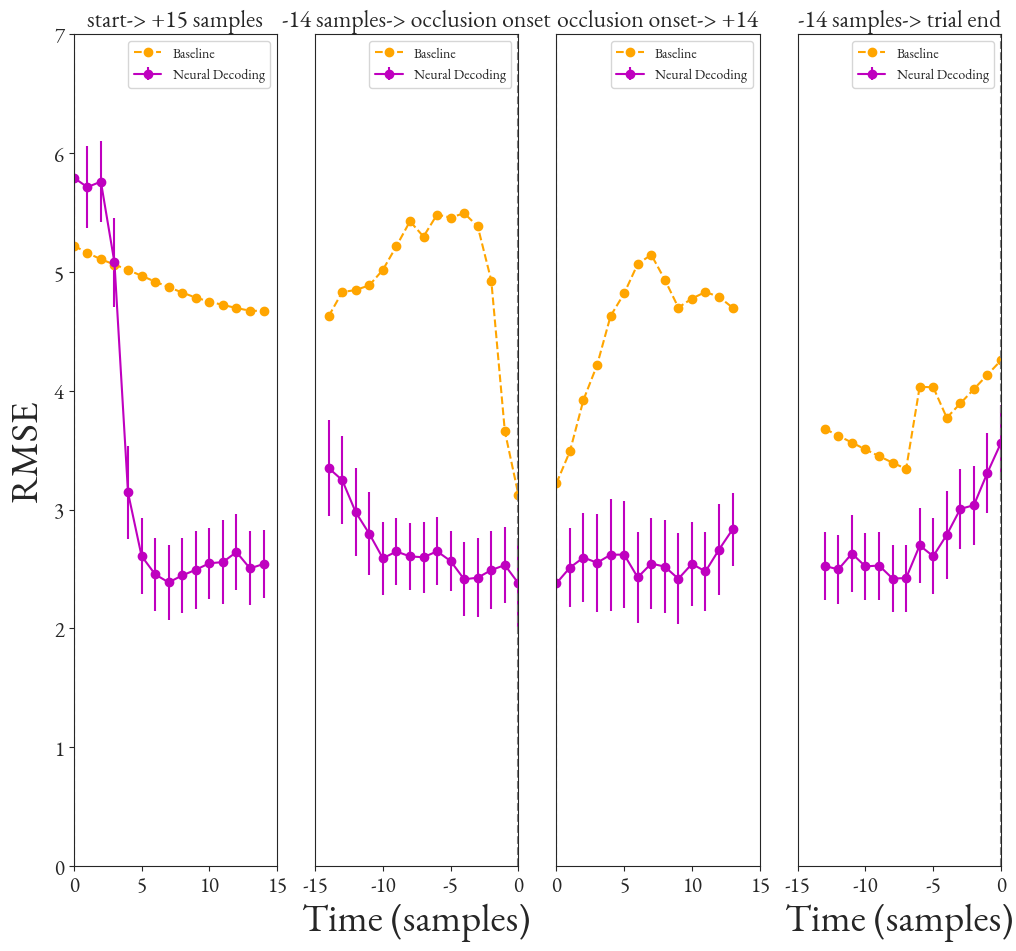

In [39]:
font_path = 'EB_Garamond/EBGaramond-VariableFont_wght.ttf'
eb_garamond = fm.FontProperties(fname=font_path)

f, axes = plt.subplots(1, 4, figsize=(10.26, 9.62))
ylim_all = [0, 7]
subplot_titles = [
    'start-> +15 samples',
    '-14 samples-> occlusion onset',
    'occlusion onset-> +14',
    '-14 samples-> trial end'
]

for ax, title in zip(axes.flat, subplot_titles):
    ax.set_title(title, fontsize=40, pad=12)

for mfi, mask_fn in enumerate(['start_occ_pad0', 'occ_end_pad0']):
    rmse_alignstart = (res[mask_fn]['mse_t'][:, :, beh_idx_mat[0]] +
                       res[mask_fn]['mse_t'][:, :, beh_idx_mat[1]]) ** 0.5
    rmse_alignend = (res[mask_fn]['mse_t2'][:, :, beh_idx_mat[0]] +
                     res[mask_fn]['mse_t2'][:, :, beh_idx_mat[1]]) ** 0.5

    min_timesteps = 15 if 'start' in mask_fn else 14

    # === START-ALIGNED ===
    ax = axes[mfi * 2]
    t_start = np.arange(0, min_timesteps)

    ax.errorbar(t_start,
                np.nanmean(rmse_alignstart[:, t_start], axis=0),
                np.nanstd(rmse_alignstart[:, t_start], axis=0),
                fmt='-mo', label='Neural Decoding')

    if 'start' in mask_fn:
        baseline_start = np.nanmean(filtered_star_occ[:, t_start], axis=0)
    else:
        baseline_start = np.nanmean(filtered_occ_end[:, t_start], axis=0)

    ax.plot(t_start, baseline_start, '--o', color='orange', label='Baseline')

    ax.set_ylim(ylim_all)
    ax.set_xlim([0, 15])  # Make sure tick 15 shows
    ax.set_xticks([0, 5, 10, 15])
    ax.set_xticklabels(['0', '5', '10', '15'])
    ax.axvline(0, linestyle='--', color='gray')

    ax.set_title(subplot_titles[mfi * 2], fontproperties=eb_garamond, fontsize=17)
    ax.tick_params(axis='both', labelsize=20)

    # Format tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(eb_garamond)
        label.set_weight('bold')
        label.set_fontsize(15)

    if mfi == 0:
        ax.set_ylabel('RMSE', fontproperties=eb_garamond, fontsize=28)

    ax.legend(prop=eb_garamond, fontsize=16)

    # === END-ALIGNED ===
    ax = axes[mfi * 2 + 1]
    t_end = np.arange(0, min_timesteps)

    ax.errorbar(t_end - min_timesteps + 1,
                np.nanmean(rmse_alignend[:, -min_timesteps:], axis=0),
                np.nanstd(rmse_alignend[:, -min_timesteps:], axis=0),
                fmt='-mo', label='Neural Decoding')

    if 'start' in mask_fn:
        baseline_end = np.nanmean(filtered_star_occ[:, -min_timesteps:], axis=0)
    else:
        baseline_end = np.nanmean(filtered_occ_end[:, -min_timesteps:], axis=0)

    ax.plot(t_end - min_timesteps + 1, baseline_end, '--o', color='orange', label='Baseline')

    ax.set_ylim(ylim_all)
    ax.set_xlim([-14, 0])
    ax.set_xticks([-15, -10, -5, 0])
    ax.set_xticklabels(['-15', '-10', '-5', '0'])
    ax.axvline(0, linestyle='--', color='gray')

    ax.set_title(subplot_titles[mfi * 2 + 1], fontproperties=eb_garamond, fontsize=17)
    ax.set_xlabel('Time (samples)', fontproperties=eb_garamond, fontsize=28)
    ax.tick_params(axis='both', labelsize=20)

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(eb_garamond)
        label.set_weight('bold')
        label.set_fontsize(15)

    if mfi == 0:
        ax.set_ylabel('RMSE', fontproperties=eb_garamond, fontsize=28)

    ax.legend(prop=eb_garamond, fontsize=16)

# Hide y-axis on right 3 plots
for i in [1, 2, 3]:
    axes[i].get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig("decoded_vs_basline.png", dpi=300, bbox_inches='tight')
plt.show()



In [40]:
print(res['start_occ_pad0'])
print(res['occ_end_pad0'])         

{'r_t': array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, 

In [41]:
print("start_occ_pad0 — baseline_end =", baseline_end)


start_occ_pad0 — baseline_end = [3.67995693 3.62178574 3.56394717 3.50659684 3.45003064 3.39487294
 3.34267207 4.03323283 4.02996991 3.77281602 3.8936077  4.01439995
 4.13519995 4.25599937]


In [42]:
print(star_occ)
print(occ_end)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [43]:
print(f"t_vec min/max: {t_vec.min()}/{t_vec.max()}")
print(f"rmse_start shape: {rmse_start.shape}")
print(f"rmse_end shape: {rmse_end.shape}")

NameError: name 't_vec' is not defined

In [ ]:
for key, val in res['start_occ_pad0'].items():
    print(f"{key}: shape = {np.shape(val)}")


In [ ]:
decoding_mean.shape


In [ ]:
filtered_star_occ.shape

In [ ]:
filtered_occ_end.shape

In [ ]:
t.shape

In [ ]:
start_occ_pad0.shape

In [ ]:
print(rmse_alignstart.shape)
print(rmse_alignend.shape)

In [ ]:
rmse_alignstart[:10]

In [ ]:
rmse_alignend[rse[:10]

In [ ]:
print(star_occ.shape)

In [ ]:
star_occ[:10]

In [ ]:
print(occ_end.shape)

In [ ]:
occ_end[:10]

In [ ]:
filtered_star_occ.shape # what we are using the figures above

In [ ]:
filtered_star_occ[:10]

In [ ]:
print(filtered_occ_end.shape)

In [ ]:
filtered_occ_end[:10]

In [ ]:
baseline.shape

In [ ]:
occ_end.shape

In [ ]:
rmse_alignstart.shape

In [ ]:
ax.errorbar(t, np.nanmean(filtered_star_occ[:, t], axis=0),
                np.nanstd(filtered_star_occ[:, t], axis=0), fmt='-mo')
    ax.set_ylim(ylim_all)
    ax.axvline(0, linestyle='--', color=[0.5, 0.5, 0.5])
    rr_gpu.make_axis_nice(ax)
    
            
    ax = axes[mfi * 2 + 1]
    t = np.arange(-min_timesteps, 0, 1)
    ax.errorbar(t, np.nanmean(filtered_occ_end[:, t], axis=0),
                np.nanstd(filtered_occ_end[:, t], axis=0), fmt='-mo')
    ax.set_ylim(ylim_all)
    ax.axvline(0, linestyle='--', color=[0.5, 0.5, 0.5])
    rr_gpu.make_axis_nice(ax)

for i in [1, 2, 3]:
    axes[i].axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


res = self.get_metrics_unrolled_and_remasked(time_idx=time_idx)


#f, axes = plot_average_metric(res)

#f, axes = plot_timecourse_of_error(res_,self.subject_i

In [ ]:
res_remasked = self.get_predictions_unrolled_and_remasked_base(time_idx=time_idx)

# # get x/y for true and predicted, shape = (23, 79, 100)
# true_all = res_remasked['true']['start_end_pad0']
# pred_all = res_remasked['pred']['start_end_pad0']

# mean over trials, result: (79, 100)
true_x = np.nanmean(res_remasked['true']['start_end_pad0'][:, 0, :, :], axis=0)
true_y = np.nanmean(res_remasked['true']['start_end_pad0'][:, 1, :, :], axis=0)

neural_prediction_x = np.nanmean(res_remasked['pred']['start_end_pad0'][:, 0, :, :], axis=0)
neural_prediction_y = np.nanmean(res_remasked['pred']['start_end_pad0'][:, 1, :, :], axis=0)


task_indices = [0, 54, 78]

fig, axs = plt.subplots(len(task_indices), 1, figsize=(13.92, 9.96*len(task_indices)), sharex=True, sharey=True)

for i, task_idx in enumerate(task_indices):
    ax = axs[i]
    ax.plot(true_x[task_idx], true_y[task_idx], 'k-', label='True trajectory')
    ax.plot(neural_prediction_x[task_idx], neural_prediction_y[task_idx], 'r--', label='Neural prediction')
    ax.set_title(f'Task condition {task_idx}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.legend()
    ax.grid(True)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [ ]:
font_path = 'EB_Garamond/EBGaramond-VariableFont_wght.ttf'
eb_garamond = fm.FontProperties(fname=font_path)

rcParams['font.family'] = 'EB Garamond'

res_remasked = self.get_predictions_unrolled_and_remasked_base(time_idx=time_idx)

# Extract true and predicted mean trajectories
true_x = np.nanmean(res_remasked['true']['start_end_pad0'][:, 0, :, :], axis=0)
true_y = np.nanmean(res_remasked['true']['start_end_pad0'][:, 1, :, :], axis=0)
neural_prediction_x = np.nanmean(res_remasked['pred']['start_end_pad0'][:, 0, :, :], axis=0)
neural_prediction_y = np.nanmean(res_remasked['pred']['start_end_pad0'][:, 1, :, :], axis=0)

# Define task indices and their visual colors
task_indices = [0, 23, 54, 78]
colors = ['orange', 'purple', 'yellow', 'magenta']

fig, ax = plt.subplots(figsize=(9.55, 11.6))


for task_idx, color in zip(task_indices, colors):
    # 1. True trajectory → black dashed outline behind color solid line
    ax.plot(true_x[task_idx], true_y[task_idx],
            linestyle='--', color='black', linewidth=4, zorder=1)
    ax.plot(true_x[task_idx], true_y[task_idx],
            linestyle='-', color=color, linewidth=2, zorder=2)

    # 2. Neural prediction → dashed line in same color
    ax.plot(neural_prediction_x[task_idx], neural_prediction_y[task_idx],
            linestyle='--', color=color, linewidth=2, zorder=0)

# ax.set_title("True vs Neural Predicted Trajectories")
ax.set_xlabel("X Position", fontproperties=eb_garamond, fontsize=30)
ax.set_ylabel("Y Position", fontproperties=eb_garamond, fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=23)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(eb_garamond)
    label.set_fontweight('bold')
    label.setfontsize(15)


ax.legend(prop=eb_garamond)
ax.grid(True)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

